# Cutzamala NDWI Processing

This notebook takes the processing made for Nuevo Leon's presas (public_interest_topics > niveles_presas > 02_ndwi_completedataset_analysis), simplifies and produces similar outputs in order to analyse three dams of the Cutzamala system..

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Notebook config

In [2]:
# -------------------------------------------------------- DATABASE (CHANGE ONLY IF DATABASED CHANGED)
# Query load data
raster_schema = 'raster_analysis'
raster_gdf_table = 'ndwi_analysis_hex'
complete_raster_df_table = 'ndwi_complete_dataset_hex'

# -------------------------------------------------------- AREA OF INTEREST
#Cities are dam names
city_list = ['presa_elbosque','presa_valledebravo','presa_villavictoria']

# -------------------------------------------------------- ANALYSIS
#Save space in disk deleting data not used again?
save_space = False

#DATA ANALYSIS - Calculate graph of monthly behaviour all years?
seasonal_behaviour = True

#DATA ANALYSIS - Plot bar charts of categorical behaviour (one for each dam)?
dam_bar_charts = True

#DATA ANALYSIS - Plot each dam shape (water/not water) through time?
plot_dams_shape = False

# -------------------------------------------------------- OUTPUT
#EXPORT DATA - Save plots in output?
save_plots = True

## Data Load

## Load data - Dams

In [3]:
# --- LOAD DATA
# Load raster hex
print("Loading raster hex data.")
query = f"SELECT * FROM {raster_schema}.{raster_gdf_table} WHERE \"city\" IN {str(tuple(city_list))} "
ndwi_hex = aup.gdf_from_query(query,geometry_col='geometry')

# Load complete dataset for dams (aprox. 900s)
print("Loading raster complete dataset.")
query = f"SELECT * FROM {raster_schema}.{complete_raster_df_table} WHERE \"city\" IN {str(tuple(city_list))} "
complete_dataset = aup.df_from_query(query)

# Load dams shapes
print("Loading dams shapes.")
poly = gpd.GeoDataFrame()
for city in city_list:
    city_gdf = gpd.read_file(f"../../../data/external/temporal_todocker/{city}.gpkg")
    poly = pd.concat([poly,city_gdf])
poly.reset_index(inplace=True)
columns_tokeep = ['Name','geometry']
poly = poly[columns_tokeep]

# --- CLIP LOADED HEX DATA TO DAMS SHAPES
print("Clipping hex data to dams shapes.")
# Find hex centroids
gdf = ndwi_hex.to_crs("EPSG:6372")
centroids = gdf.centroid
centroids = centroids.to_crs("EPSG:4326")
# Turn them into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})
centroids_gdf.set_geometry('geometry',inplace=True)
# Intersect centroids with original analysed_raster to keep hex_id in centroids
centroids_hexid = gpd.overlay(centroids_gdf,ndwi_hex,keep_geom_type=True)
columns_tokeep = ['hex_id','geometry']
centroids_hexid = centroids_hexid[columns_tokeep]
# Intersect spatially centroids with dam
centroids_hexid_dam = gpd.overlay(centroids_hexid,poly,keep_geom_type=True)
# Select hexagons from centroids's hex_id
centroids_hexid_dam_f = centroids_hexid_dam['hex_id']
ndwi_hex_dams = pd.merge(centroids_hexid_dam_f,ndwi_hex, on='hex_id')
ndwi_hex_dams = ndwi_hex_dams.set_geometry('geometry')
#Save space in disk deleting:
if save_space:
    del ndwi_hex
    del centroids
    del centroids_gdf
    del centroids_hexid
    del centroids_hexid_dam
    del centroids_hexid_dam_f
    
# --- CLIP LOADED COMPLETE DATASET TO DAMS SHAPES
print("Clipping complete dataset to dams shapes.")
gdf1 = ndwi_hex_dams.copy()[['hex_id','res','city','geometry']]
df2 = complete_dataset.copy()[['hex_id','ndwi','month', 'year']]
complete_dataset_dams = pd.merge(gdf1, df2, how='inner', on='hex_id')
#Save space in disk deleting:
if save_space:
    del gdf1
    del df2
    del complete_dataset

print("Finished loading and clipping data.")
print(f"Loaded {ndwi_hex_dams.shape[0]} hexs for {len(ndwi_hex_dams.city.unique())} cities.")
print(f"Loaded {complete_dataset_dams.shape[0]} complete dataset datapoints for {len(complete_dataset_dams.city.unique())} cities.")

Loading raster hex data.
Loading raster complete dataset.
Loading dams shapes.
Clipping hex data to dams shapes.
Clipping complete dataset to dams shapes.
Finished loading and clipping data.
Loaded 25669 hexs for 3 cities.
Loaded 1998674 complete dataset datapoints for 3 cities.


In [4]:
# Show
print(ndwi_hex_dams.shape)
ndwi_hex_dams.head(1)

(25669, 11)


,hex_id,res,ndwi_mean,ndwi_std,ndwi_median,ndwi_max,ndwi_min,ndwi_diff,ndwi_tend,city,geometry
0,8b498636e91afff,11,0.427997,0.313992,0.506361,0.731366,0.031265,0.700101,-0.004693,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3..."


In [5]:
# Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(1)

(1998674, 7)


,hex_id,res,city,geometry,ndwi,month,year
0,8b498636e91afff,11,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3...",0.976958,1,2016


### If need to load one by one

In [6]:
one_by_one = False

#### Load raster hex

In [7]:
if one_by_one:
    # Load raster hex
    query = f"SELECT * FROM {raster_schema}.{raster_gdf_table} WHERE \"city\" IN {str(tuple(city_list))} "
    ndwi_hex = aup.gdf_from_query(query,geometry_col='geometry')

# Show
#print(ndwi_hex.shape)
#ndwi_hex.head(2)

#### Load complete dataset

In [8]:
if one_by_one:
    # Load complete dataset for dams (aprox. 900s)
    query = f"SELECT * FROM {raster_schema}.{complete_raster_df_table} WHERE \"city\" IN {str(tuple(city_list))} "
    complete_dataset = aup.df_from_query(query)

# Show
#print(complete_dataset.shape)
#complete_dataset.head(2)

#### Clip loaded data to dams polygons

In [9]:
if one_by_one:
    elbosque = gpd.read_file("../../../data/external/temporal_todocker/presa_elbosque.gpkg")
    valledebravo = gpd.read_file("../../../data/external/temporal_todocker/presa_valledebravo.gpkg")
    villavictoria = gpd.read_file("../../../data/external/temporal_todocker/presa_villavictoria.gpkg")
    
    # Create areas of interest
    gdfs = [elbosque,valledebravo,villavictoria]
    poly = pd.concat(gdfs)
    
    poly.reset_index(inplace=True)
    columns_tokeep = ['Name','geometry']
    poly = poly[columns_tokeep]
    
    poly.plot()

In [10]:
if one_by_one:
    # Find hex centroids
    gdf = ndwi_hex.to_crs("EPSG:6372")
    centroids = gdf.centroid
    centroids = centroids.to_crs("EPSG:4326")
    
    # Turn them into gdf
    centroids_gdf = gpd.GeoDataFrame(centroids)
    centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})
    centroids_gdf.set_geometry('geometry',inplace=True)
    
    # Intersect centroids with original analysed_raster to keep hex_id in centroids
    centroids_hexid = gpd.overlay(centroids_gdf,ndwi_hex,keep_geom_type=True)
    columns_tokeep = ['hex_id','geometry']
    centroids_hexid = centroids_hexid[columns_tokeep]
    
    # Intersect spatially centroids with dam
    centroids_hexid_dam = gpd.overlay(centroids_hexid,poly,keep_geom_type=True)
    
    # Select hexagons from centroids's hex_id
    centroids_hexid_dam_f = centroids_hexid_dam['hex_id']
    ndwi_hex_dams = pd.merge(centroids_hexid_dam_f,ndwi_hex, on='hex_id')
    ndwi_hex_dams = ndwi_hex_dams.set_geometry('geometry')
    
    #Save space in disk deleting:
    if save_space:
        del ndwi_hex
        del centroids
        del centroids_gdf
        del centroids_hexid
        del centroids_hexid_dam
        del centroids_hexid_dam_f
    
    ndwi_hex_dams.plot()

#### Clip complete dataset to dams shapes

In [11]:
if one_by_one:
    gdf1 = ndwi_hex_dams.copy()[['hex_id','res','city','geometry']]
    df2 = complete_dataset.copy()[['hex_id','ndwi','month', 'year']]
    
    complete_dataset_dams = pd.merge(gdf1, df2, how='inner', on='hex_id')
    
    #Save space in disk deleting:
    if save_space:
        del gdf1
        del df2
        del complete_dataset

#Show
#print(complete_dataset_dams.shape)
#complete_dataset_dams.head(2)

## Data treatment

### Create datetime data

In [6]:
#Creates datetime data by adding month (string) + / + year (string)
complete_dataset_dams['date'] = pd.to_datetime(complete_dataset_dams['month'].astype(str) + '/' + complete_dataset_dams['year'].astype(str))

#Strips the day, leaving month and year
complete_dataset_dams['date'] = complete_dataset_dams['date'].apply(lambda x: x.strftime('%Y-%m'))

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

/tmp/ipykernel_62503/3162562602.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  complete_dataset_dams['date'] = pd.to_datetime(complete_dataset_dams['month'].astype(str) + '/' + complete_dataset_dams['year'].astype(str))


(1998674, 8)


,hex_id,res,city,geometry,ndwi,month,year,date
0,8b498636e91afff,11,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3...",0.976958,1,2016,2016-01
1,8b498636e91afff,11,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3...",0.976958,2,2016,2016-02


### Data treatment - Create raster categories (from documentation)

In [7]:
# Creating vegetation categories
complete_dataset_dams['ndwi_category'] = np.nan

complete_dataset_dams.loc[complete_dataset_dams.ndwi>=0.2 , 'ndwi_category'] = 'Water surface'        
complete_dataset_dams.loc[(complete_dataset_dams.ndwi>=0.0)&
             (complete_dataset_dams.ndwi<0.2), 'ndwi_category'] = 'Flooding, humidity'
complete_dataset_dams.loc[(complete_dataset_dams.ndwi>=-0.3)&
             (complete_dataset_dams.ndwi<0.0), 'ndwi_category'] = 'Moderate drought, non-aqueous surfaces'
complete_dataset_dams.loc[(complete_dataset_dams.ndwi<-0.3), 'ndwi_category'] = 'Drought, non-aqueous surfaces'

# Ordering data
categories = ['Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 'Flooding, humidity', 'Water surface']
complete_dataset_dams['ndwi_category'] = pd.Categorical(complete_dataset_dams['ndwi_category'], categories=categories, ordered=True)

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

(1998674, 9)


,hex_id,res,city,geometry,ndwi,month,year,date,ndwi_category
0,8b498636e91afff,11,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3...",0.976958,1,2016,2016-01,Water surface
1,8b498636e91afff,11,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3...",0.976958,2,2016,2016-02,Water surface


### Data treatment - Differenciate hex with and without water (from experience)

In [8]:
#Select surfaces with water
water_list = ['Flooding, humidity', 'Water surface']

#Differenciate
complete_dataset_dams.loc[:,'hex_water'] = complete_dataset_dams['ndwi_category'].apply(lambda x: 1 if x in water_list else 0)

#Show
print(complete_dataset_dams.shape)
complete_dataset_dams.head(2)

(1998674, 10)


,hex_id,res,city,geometry,ndwi,month,year,date,ndwi_category,hex_water
0,8b498636e91afff,11,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3...",0.976958,1,2016,2016-01,Water surface,1
1,8b498636e91afff,11,presa_elbosque,"POLYGON ((-100.41678 19.38473, -100.41660 19.3...",0.976958,2,2016,2016-02,Water surface,1


## Data analysis

### Data analysis - NDWI mean and categories count by date
Counts NDWI mean and NDWI Categories ('Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 'Flooding, humidity', 'Water surface') by date by dam

In [9]:
#Calculate average hex area according to resolution and location
available_dates = len(complete_dataset_dams.date.unique())
data_rows = available_dates

#Output dataset
behaviour_bydate = pd.DataFrame()

#Loop for each city (dam)
for city in complete_dataset_dams.city.unique():

    #Create empty temporary dataFrame
    cols = ['date', 'mean_ndwi']
    temp_df = pd.DataFrame(columns=cols, index=range(data_rows))
    temp_df['city'] = city 

    #Loop for each row (date)
    row = 0

    #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD (dam)
    complete_bycity = complete_dataset_dams.loc[(complete_dataset_dams.city == city)]

    #Loop for each date in city (Dam)
    for date in complete_bycity.date.unique():
        #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD (dam) Y LA FECHA.
        complete_bydate = complete_bycity.loc[(complete_bycity.date == date)]
        
        #Find mean ndwi of date in city
        ndwi_value = complete_bydate.ndwi.mean()
        #Register data in DataFrame
        temp_df.loc[row,'date'] = date
        temp_df.loc[row,'mean_ndwi'] = ndwi_value

        #Loop for each raster category in the date in the city (dam)
        categories = ['Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 'Flooding, humidity', 'Water surface']
        for cat in categories:
            #TERCERA SUBDIVISIÓN: DATASET DE LA CIUDAD, LA FECHA Y LA CATEGORÍA.
            complete_bydate_cat = complete_bydate.loc[(complete_bydate.ndwi_category == cat)]
            #Find count of hexs of this category on this date on this city
            hexcount = complete_bydate_cat.shape[0]
            #Register data in DataFrame
            temp_df.loc[row, cat] = hexcount

        #Next row (date) in city (dam) dataFrame
        row = row + 1

    #When all dates of city are over, concat and re-start count and data for following city (dam)
    behaviour_bydate = pd.concat([behaviour_bydate,temp_df])
    
    #Save space in disk deleting:
    if save_space:
        del complete_bycity
        del complete_bydate
        del temp_df

#Save date data
behaviour_bydate['month'] = behaviour_bydate['date'].apply(lambda x: pd.Timestamp(x).month)
behaviour_bydate['year'] = behaviour_bydate['date'].apply(lambda x: pd.Timestamp(x).year)

#Final format
behaviour_bydate = behaviour_bydate[['date','year','month','mean_ndwi',
                                     'Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 
                                     'Flooding, humidity', 'Water surface','city']]

#Show
print(behaviour_bydate.shape)
behaviour_bydate.head(2)

(294, 9)


,date,year,month,mean_ndwi,"Drought, non-aqueous surfaces","Moderate drought, non-aqueous surfaces","Flooding, humidity",Water surface,city
0,2016-01,2016.0,1.0,0.729188,388.0,114.0,66.0,3564.0,presa_elbosque
1,2016-02,2016.0,2.0,0.729188,388.0,114.0,66.0,3564.0,presa_elbosque


### Data analysis - Data tendency
Once mean_ndwi is calculated for each dam on each date, it is posible to analyse mean_ndwi tendency on each dam through time.

In [10]:
import pymannkendall as mk

for city in behaviour_bydate.city.unique():
    #Data for each dam
    behaviour_bycity = behaviour_bydate.loc[(behaviour_bydate.city == city)]
    behaviour_bycity = behaviour_bycity[['date','mean_ndwi']]
    #Mann-Kendall Test 
    test = mk.original_test(behaviour_bycity['mean_ndwi'])
    print('{}'.format(city))
    print('{}'.format(test))

presa_elbosque
Mann_Kendall_Test(trend='decreasing', h=True, p=2.5070001776983375e-05, z=-4.2141685508995295, Tau=-0.2890805806858826, s=-1374.0, var_s=106149.33333333333, slope=-0.004322050401881873, intercept=0.43696674056025975)
presa_valledebravo
Mann_Kendall_Test(trend='decreasing', h=True, p=3.752553823233029e-14, z=-7.569446034813303, Tau=-0.6008885597926694, s=-1623.0, var_s=45917.0, slope=-0.0056875201193421505, intercept=0.4390507854680307)
presa_villavictoria
Mann_Kendall_Test(trend='decreasing', h=True, p=3.808731108279062e-12, z=-6.944103390753511, Tau=-0.5512773047019622, s=-1489.0, var_s=45917.0, slope=-0.00639395419495702, intercept=0.4579216904699335)


### Data analysis - Visualization of seasonal behaviour of data (joined by month to reduce data points visualized)

Creates a lineplot graph where the X axis has every month of the year. It shows the seasonal behaviour of data.

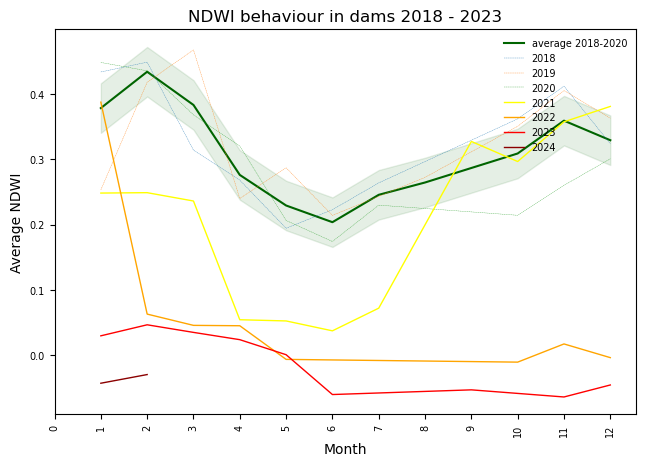

In [11]:
if seasonal_behaviour:
    columns_tokeep = ['date','month','percentage']

    # ---------- Plotting whole data by month (main line) ----------
    # DATA
    complete_dataset_dams_f = complete_dataset_dams.loc[(complete_dataset_dams.year >= 2018) & (complete_dataset_dams.year <= 2020)]
    complete_bymonth = complete_dataset_dams_f.groupby('month').agg({'month':np.mean,'ndwi':np.mean})

    # ------- DATA AND CONFIDENCE INTERVAL PLOT -------
    #Confidence interval data
    x = complete_bymonth.month
    y = complete_bymonth.ndwi
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    #Plot
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.plot(x,y, label = 'average 2018-2020',color = 'darkgreen')
    ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

    # ---------- MONTHLY DATA (dotted lines) ----------

    # Find all data years
    available_years = list(complete_dataset_dams['year'].unique())
    available_years.remove(2016) #Removed because only available for presa_elbosque
    available_years.remove(2017) #Removed because only available for presa_elbosque

    #Iterate over each year
    for current_year in available_years:
        #Isolating df
        year_dataset_dams = complete_dataset_dams.loc[(complete_dataset_dams.year == current_year)]
        #Grouping by month    
        data_bymonth = year_dataset_dams.groupby('month').agg({'ndwi':np.mean})
        #Plotting
        if current_year == 2021:
            plt.plot(data_bymonth, linewidth = 1, label=current_year,c='yellow');
        elif current_year == 2022:
            plt.plot(data_bymonth, linewidth = 1, label=current_year,c='orange');
        elif current_year == 2023:
            plt.plot(data_bymonth, linewidth = 1, label=current_year,c='red');
        elif current_year == 2024:
            plt.plot(data_bymonth, linewidth = 1, label=current_year,c='darkred');
        else:
            plt.plot(data_bymonth, '--', linewidth = 0.25, label=current_year);


    # ---------- FORMAT ----------
    # Format - Titles
    plt.title('NDWI behaviour in dams 2018 - 2023')
    plt.xlabel('Month')
    plt.ylabel('Average NDWI')

    # Format - x ticks
    # Tag all 12 months
    plt.xticks(np.arange(0, 13))
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Format - y ticks
    y = plt.gca().yaxis
    for item in y.get_ticklabels():
        item.set_size(7)

    # Format - Legend
    plt.legend(frameon=False,
               loc=1, 
               fontsize = 7)

    #Save space in disk deleting:
    if save_space:
        del complete_dataset_dams_f
        del complete_bymonth
        del year_dataset_dams
        del data_bymonth

    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig("../../../output/figures/ndwi/cutzamala/ndwi_seasonal_behaviour_lineplot.svg")

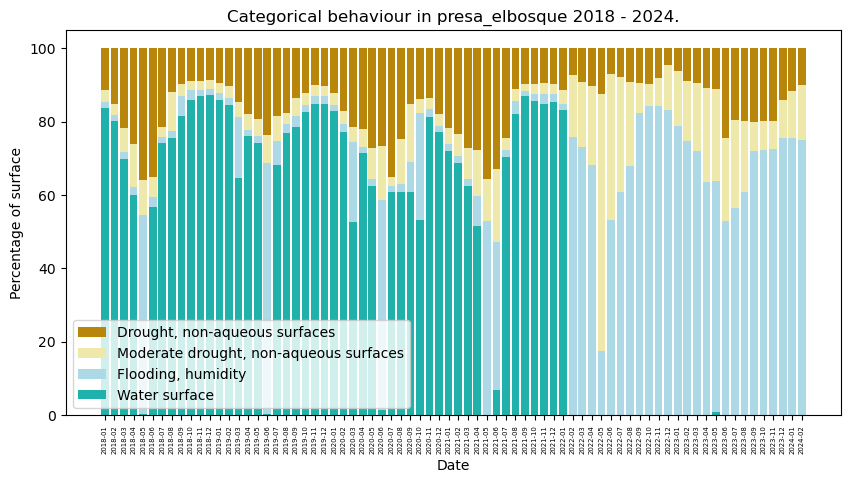

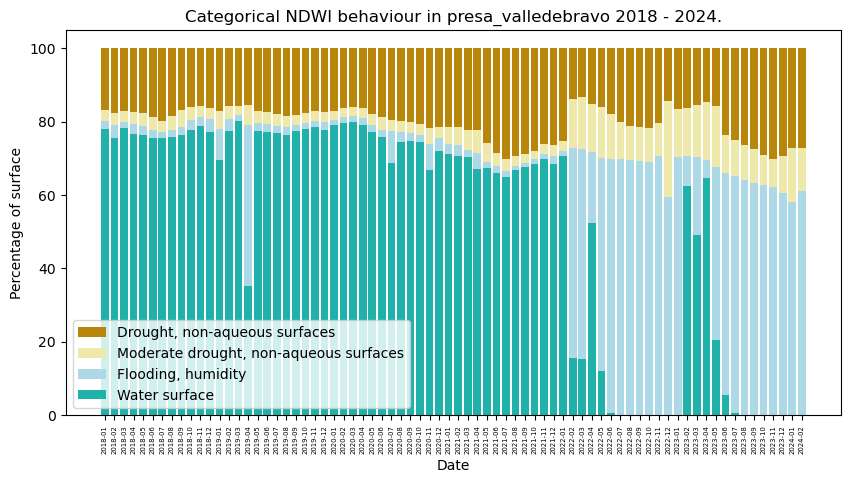

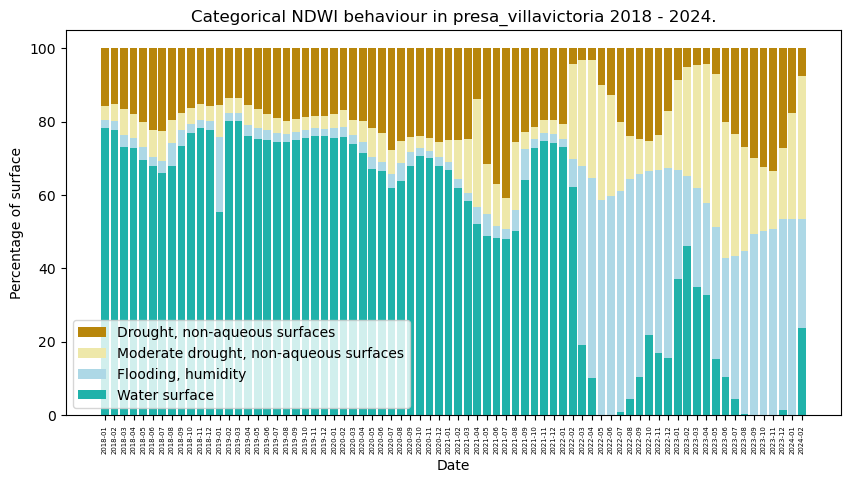

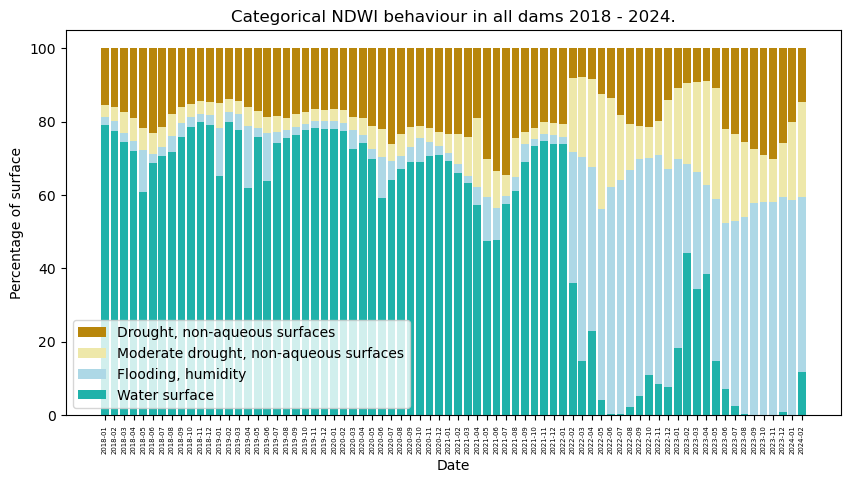

In [12]:
if dam_bar_charts:

    # Added later in order to remove 2016 and 2017 (Data available for presa_elbosque only)
    filtered_dates = [2018,2019,2020,2021,2022,2023,2024]
    behaviour_bydate_f = behaviour_bydate.loc[behaviour_bydate['year'].isin(filtered_dates)].copy()
    
    # Data storage for all dams
    all_dams_behaviour = pd.DataFrame()
    i = 0
    
    #Iterate over each city
    for city in behaviour_bydate_f.city.unique():
        
        #--------------- Isolate data for dam and clean data ---------------
        dam_behaviour = behaviour_bydate_f.loc[(behaviour_bydate_f.city == city)]
        dam_behaviour = dam_behaviour.dropna(axis=0) # Added drop nas because Cutzamala dams data differe on date
        
        #--------------- Create series of data by category for bar chart plot ---------------
        water = dam_behaviour[['date','Water surface']].copy()
        flood = dam_behaviour[['date','Flooding, humidity']].copy()
        moderate = dam_behaviour[['date','Moderate drought, non-aqueous surfaces']].copy()
        drought = dam_behaviour[['date','Drought, non-aqueous surfaces']].copy()
        
        #--------------- Plot dam data ---------------
        x = water['date']
        total_hexs = water['Water surface']+flood['Flooding, humidity']+moderate['Moderate drought, non-aqueous surfaces']+drought['Drought, non-aqueous surfaces']
        
        y4 = (drought['Drought, non-aqueous surfaces'] / total_hexs)*100
        y3 = (moderate['Moderate drought, non-aqueous surfaces'] / total_hexs)*100
        y2 = (flood['Flooding, humidity'] / total_hexs)*100
        y1 = (water['Water surface'] / total_hexs)*100
        
        plt.figure(figsize=(10,5))
        plt.bar(x, y4, bottom=y1+y2+y3, color='darkgoldenrod',label='Drought, non-aqueous surfaces')
        plt.bar(x, y3, bottom=y1+y2, color='palegoldenrod',label='Moderate drought, non-aqueous surfaces')
        plt.bar(x, y2, bottom=y1, color='lightblue',label='Flooding, humidity')
        plt.bar(x, y1, color='lightseagreen',label='Water surface')
        
        # ---------- Format ----------
        # Format - Titles
        if city == 'presa_elbosque':
            plt.title(f"Categorical behaviour in {city} 2018 - 2024.")
        else:
            plt.title(f"Categorical NDWI behaviour in {city} 2018 - 2024.")
        plt.xlabel('Date')
        plt.ylabel('Percentage of surface')
        
        # Format - x ticks
        # Rotate ticks
        x = plt.gca().xaxis
        for item in x.get_ticklabels():
            item.set_rotation(90)
            item.set_size(5)
        
        # Format - Legend
        plt.legend(frameon=False,
                   loc='upper left',
                   fontsize = 5)
        
        legend = plt.legend(frameon = 1)
        legend.fontsize = 5
        frame = legend.get_frame()
        frame.set_facecolor('white')
        
        # ---------- Save Plot ----------
        if save_plots:
            plt.savefig(f"../../../output/figures/ndwi/cutzamala/historic_barplot_{city}.svg")

        #--------------- Create series of data by category for ALL DAMS bar chart plot ---------------
        if i == 0: #Add date column with concat, then merge rest of dam data
            all_dams_behaviour = pd.concat([all_dams_behaviour,water])
            all_dams_behaviour.rename(columns={'Water surface':'all_water'},inplace=True)
            
            all_dams_behaviour = all_dams_behaviour.merge(flood, on='date')
            all_dams_behaviour.rename(columns={'Flooding, humidity':'all_flooding'},inplace=True)
            
            all_dams_behaviour = all_dams_behaviour.merge(moderate, on='date')
            all_dams_behaviour.rename(columns={'Moderate drought, non-aqueous surfaces':'all_moderate'},inplace=True)
            
            all_dams_behaviour = all_dams_behaviour.merge(drought, on='date')
            all_dams_behaviour.rename(columns={'Drought, non-aqueous surfaces':'all_drought'},inplace=True)
            
        else: # Merge current dam data (Will remove years where there is no data for any dam, in this case keeping 2018-2024)
            all_dams_behaviour = all_dams_behaviour.merge(water, on='date')
            all_dams_behaviour['all_water'] = all_dams_behaviour['all_water'] + all_dams_behaviour['Water surface']
            all_dams_behaviour.drop(columns=['Water surface'],inplace=True)

            all_dams_behaviour = all_dams_behaviour.merge(flood, on='date')
            all_dams_behaviour['all_flooding'] = all_dams_behaviour['all_flooding'] + all_dams_behaviour['Flooding, humidity']
            all_dams_behaviour.drop(columns=['Flooding, humidity'],inplace=True)
            
            all_dams_behaviour = all_dams_behaviour.merge(moderate, on='date')
            all_dams_behaviour['all_moderate'] = all_dams_behaviour['all_moderate'] + all_dams_behaviour['Moderate drought, non-aqueous surfaces']
            all_dams_behaviour.drop(columns=['Moderate drought, non-aqueous surfaces'],inplace=True)
            
            all_dams_behaviour = all_dams_behaviour.merge(drought, on='date')
            all_dams_behaviour['all_drought'] = all_dams_behaviour['all_drought'] + all_dams_behaviour['Drought, non-aqueous surfaces']
            all_dams_behaviour.drop(columns=['Drought, non-aqueous surfaces'],inplace=True)

        i += 1
        
    #--------------- Plot ALL DAMS data ---------------
    x = water['date']
    total_hexs = all_dams_behaviour['all_water']+all_dams_behaviour['all_flooding']+all_dams_behaviour['all_moderate']+all_dams_behaviour['all_drought']
    
    y4 = (all_dams_behaviour['all_drought'] / total_hexs)*100
    y3 = (all_dams_behaviour['all_moderate'] / total_hexs)*100
    y2 = (all_dams_behaviour['all_flooding'] / total_hexs)*100
    y1 = (all_dams_behaviour['all_water'] / total_hexs)*100
    
    plt.figure(figsize=(10,5))
    plt.bar(x, y4, bottom=y1+y2+y3, color='darkgoldenrod',label='Drought, non-aqueous surfaces')
    plt.bar(x, y3, bottom=y1+y2, color='palegoldenrod',label='Moderate drought, non-aqueous surfaces')
    plt.bar(x, y2, bottom=y1, color='lightblue',label='Flooding, humidity')
    plt.bar(x, y1, color='lightseagreen',label='Water surface')
    
    # ---------- Format ----------
    # Format - Titles
    plt.title(f"Categorical NDWI behaviour in all dams 2018 - 2024.")
    plt.xlabel('Date')
    plt.ylabel('Percentage of surface')
    
    # Format - x ticks
    # Rotate ticks
    x = plt.gca().xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(5)
    
    # Format - Legend
    plt.legend(frameon=False,
               loc='upper left',
               fontsize = 5)
    
    legend = plt.legend(frameon = 1)
    legend.fontsize = 5
    frame = legend.get_frame()
    frame.set_facecolor('white')

    # ---------- Save Plot ----------
    if save_plots:
        plt.savefig(f"../../../output/figures/ndwi/cutzamala/historic_barplot_alldams.svg")

    #Save space in disk deleting:
    if save_space:
        del dam_behaviour
        del water
        del flood
        del moderate
        del drought

In [19]:
if plot_dams_shape:
    for city in city_list:
        ########## DAM SHAPE PLOT ##########
        #------------------------------ Data for dam shape ------------------------------
        dam_ndwi_hex_dams = ndwi_hex_dams.loc[ndwi_hex_dams.city == city].copy()
    
        # Find hexs with water
        dam_ndwi_hex_dams['water_hex'] = np.nan
        dam_ndwi_hex_dams.loc[dam_ndwi_hex_dams.ndwi_mean>=0.0 , 'water_hex'] = 'Water'        
        dam_ndwi_hex_dams.loc[(dam_ndwi_hex_dams.ndwi_mean<-0.0), 'water_hex'] = 'Non-aqueous surfaces'
        water_hex = dam_ndwi_hex_dams.loc[dam_ndwi_hex_dams['water_hex'] == 'Water'].copy()
    
        #Dissolve geometry
        water_hex_geom = water_hex.to_crs("EPSG:6372")
        dam_shape = water_hex_geom.dissolve()
        dam_shape = dam_shape.to_crs("EPSG:4326")
        
        #------------------------------ Plot dam shape ------------------------------
        dam_shape.plot(facecolor="none", edgecolor='red', lw=0.7)
    
        # ---------- Save Plot ----------
        if save_plots:
            plt.savefig(f"../../../output/figures/ndwi/cutzamala/maps_{city}/{city}_shape.svg")

        ########## PLOT FIRST YEARS ##########
        #------------------------------ Select data ------------------------------
        #PRIMERA SUBDIVISIÓN: DATASET DE LA CIUDAD.
        complete_dataset_dams_city = complete_dataset_dams.loc[(complete_dataset_dams.city == city)].copy()
    
        years_summary = [2018,2019,2020]
        #Loop for each year in city
        for year in years_summary:
            #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
            by_year = complete_dataset_dams_city.loc[(complete_dataset_dams_city.year == year)].copy()
            year_meandataset_byhex = by_year.groupby('hex_id').agg({'ndwi':np.mean})
    
            # Create categorical data for water / not water
            year_meandataset_byhex['water_hex'] = np.nan
            year_meandataset_byhex.loc[year_meandataset_byhex.ndwi>=0.0 , 'water_hex'] = 'Water'        
            year_meandataset_byhex.loc[(year_meandataset_byhex.ndwi<-0.0), 'water_hex'] = 'Non-aqueous surfaces'
            categories = ['Non-aqueous surfaces', 'Water']
            year_meandataset_byhex['water_hex'] = pd.Categorical(year_meandataset_byhex['water_hex'], categories=categories, ordered=True)
            
            # Merge data with geometry
            gdf1 = ndwi_hex_dams.copy()[['hex_id','geometry']]
            df2 = year_meandataset_byhex.reset_index()
            year_meandataset_geom = pd.merge(gdf1, df2, how='inner', on='hex_id')
            
            #Dissolve hexs geometry (makes output lighter)
            year_meandataset_geom = year_meandataset_geom.to_crs("EPSG:6372")
            water_shape = year_meandataset_geom.dissolve('water_hex')
            water_shape = water_shape.to_crs("EPSG:4326")
            water_shape.reset_index(inplace=True)
            water_shape = water_shape[['water_hex','geometry']]
            
            # ---------- Plot ----------
            #Date behaviour
            water_shape.plot(column="water_hex",
                             legend=True, color = ['sienna','turquoise'])
    
            # ---------- Format ----------
            # Format - Titles
            plt.title(f"{city}_hehaviour in {year}".format(city,year))
            
            # ---------- Save disk space ----------
            if save_space:
                del by_year
                del year_meandataset_byhex
                del gdf1
                del df2
                del water_shape
    
            # ---------- Save Plot ----------
            if save_plots:
                plt.savefig(F"../../../output/figures/ndwi/cutzamala/maps_{city}/{city}_hehaviour in {year}.svg")
        
        ########## PLOT MONTHS ##########
        
        #------------------------------ Select data ------------------------------
        
        years_summary = [2021,2022,2023,2024]
        #Loop for each year in city
        for year in years_summary:
            #SEGUNDA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
            by_year = complete_dataset_dams_city.loc[(complete_dataset_dams_city.year == year)].copy()
        
            #Loop for each date in city
            for date in by_year.date.unique():
                #TERCERA SUBDIVISIÓN: DATASET DE LA CIUDAD Y LA FECHA.
                month_dataset = by_year.loc[(by_year.date == date)].copy()
    
                # Create categorical data for water / not water
                month_dataset['water_hex'] = np.nan
                month_dataset.loc[month_dataset.ndwi>=0.0 , 'water_hex'] = 'Water'        
                month_dataset.loc[(month_dataset.ndwi<-0.0), 'water_hex'] = 'Non-aqueous surfaces'
                categories = ['Non-aqueous surfaces', 'Water']
                month_dataset['water_hex'] = pd.Categorical(month_dataset['water_hex'], categories=categories, ordered=True)
    
                #Dissolve geometry (makes output lighter)
                month_dataset = month_dataset.to_crs("EPSG:6372")
                water_shape = month_dataset.dissolve('water_hex')
                water_shape = water_shape.to_crs("EPSG:4326")
                water_shape.reset_index(inplace=True)
                water_shape = water_shape[['water_hex','geometry']]
                
                # ---------- Plot ----------
                #Date behaviour
                water_shape.plot(column="water_hex",
                                 legend=True,
                                 color = ['sienna','turquoise'])
    
                # ---------- Format ----------
                # Format - Titles
                plt.title(f"{city}_hehaviour in {date}")
    
                # ---------- Save Plot ----------
                if save_plots:
                    plt.savefig(f"../../../output/figures/ndwi/cutzamala/maps_{city}/{city}_hehaviour in {date}.svg")
    